### Parte 1. Lectura de datos crudos.
**Libreria de XM para datos del mercado eléctrico**

In [28]:
# Instalación de libreria XM
!pip install pydataxm 


You should consider upgrading via the 'C:\Users\itco10302\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [29]:
# Libreria lectura de datos XM
from pydataxm import *

#Librerias básicas manejo de datos
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns

#Librerias visualización
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

# Librerias análisis exploratorio
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Librerias preparación de datos para modelo
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Lectura desde API XM (Administrador del mercado mayorista de energía en Colombia). Base de datos con colecciones y variables del mercado mayorista de energía, en la que converge información relacionada con la demanda energética diaria del país, las diversas fuentes de generación electrica que componen la matriz energética colombiana, despacho térmico para la generación de energía electrica a partir diferentes tipos de combustible, variables históricas de precios, agentes generadores, entre otros.



In [30]:
# Creación de objeto API
objetoAPI = pydataxm.ReadDB()
# Con esta línea de código traemos todas las colecciones de datos de xm
df =objetoAPI.get_collections()
df.head(20)

,MetricId,MetricName,Entity,MaxDays,Type,Url,Filter,MetricUnits,MetricDescription
0,DemaReal,Demanda Real por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Demanda de usuarios regulados y no regulados q...
1,DemaReal,Demanda Real por Agente,Agente,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Comercializador,kWh,Demanda de usuarios regulados y no regulados q...
2,ExpoMoneda,Exportaciones Moneda por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP,Transferencias de Energia desde Colombia hacia...
3,DemaCome,Demanda Comercial por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Considera la demanda propia de cada comerciali...
4,Gene,Generación por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Generacion neta de cada una de las plantas Nac...
5,GeneIdea,Generación Ideal por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Despacho de generacion que resulta de consider...
6,PrecBolsNaci,Precio Bolsa Nacional por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP/kWh,Precio de oferta de la última planta flexible ...
7,RestAliv,Restricciones Aliviadas por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP,“Es el valor a cargo de los comercializadores ...
8,ConsCombustibleMBTU,Consumo Combustible MBTU por Recurso,Recurso,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Submercado Generación,MBTU,Los generadores térmicos deben reportar diaria...
9,Gene,Generación por Recurso,Recurso,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Submercado Generación,kWh,Generacion neta de cada una de las plantas Nac...


### Lectura de datos crudos desde la base de datos de XM de consumo de combustible de los agentes del sistema en MBTU
**Descripción de las variables:**
1.  Id: indicador de recurso
2. Values_Name: Tipo de combustible utilizado para la generación
3. Values_code: Nombre codificado de la central térmica.
4. Values_Hour0"n": Cantidad de energía consumida en MBTU en la hora "n" por el agente termico en un día particular.
5. Date: Día de consumo.

In [31]:
# Lectura de datos crudos del consumo de combustible en MBTU de las termoelectricas durante el periodo 2017-2023.
# Se realiza una lectura de consumo de combustible desde una fecha inicio hasta una fecha fin.
fecha_inicio = dt.date(2017, 1, 1)
fecha_fin = dt.date(2023, 12, 31)
df_ConsCombustibleMBTU = objetoAPI.request_data("ConsCombustibleMBTU",
                                    "Recurso",
                                    fecha_inicio,
                                    fecha_fin)
# tabla de datos inicial con la que se va a trabajar.
df_ConsCombustibleMBTU

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col],errors='ignore')
c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data['Date'] = pd.to_datetime(data['Date'],errors='ignore', format= '%Y-%m-%d')


,Id,Values_Name,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,...,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date
0,Recurso,ACPM,TRN1,9.73000,28.13000,27.79000,NaN,NaN,11.81000,2.43000,...,9.38000,9.38000,9.38000,9.38000,19.80000,9.73000,9.38000,9.38000,9.38000,2023-12-26
1,Recurso,CARBON,GE32,2596.83000,2073.22000,1570.20000,1649.84000,1697.32000,1911.22000,2348.90000,...,2915.58000,2902.76000,2907.81000,2902.13000,2899.19000,2900.87000,2893.73000,2902.55000,2901.71000,2023-12-26
2,Recurso,CARBON,GEC3,1859.53000,1899.67000,1892.52000,1895.46000,1893.15000,1888.74000,1886.64000,...,1320.16000,1186.11000,1258.81000,1240.11000,1222.04000,1243.26000,1327.10000,1433.42000,1632.19000,2023-12-26
3,Recurso,CARBON,PPA1,345.95685,327.42046,305.82954,272.77367,234.32007,258.33788,295.53619,...,376.66952,378.97087,378.59429,374.66106,369.55623,376.54399,380.01695,375.66529,371.85759,2023-12-26
4,Recurso,CARBON,PPA2,763.04049,703.65472,635.92550,570.22956,498.71423,501.86932,586.07511,...,819.20105,824.52964,820.18263,809.59556,800.27052,811.13805,815.13449,817.02755,818.28958,2023-12-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Recurso,GAS,PRG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.67900,320.64900,609.63300,796.00800,889.73500,880.21900,872.14600,740.93000,2017-01-30
232,Recurso,GAS,TBST,3826.77270,3830.75790,3831.75420,3828.76520,3827.76890,3832.75040,3832.75040,...,4435.50950,4364.77240,3793.89490,4025.03550,4029.02070,3966.25410,3988.17260,4423.55390,4000.12820,2017-01-30
233,Recurso,GAS,TFL1,NaN,NaN,NaN,NaN,78.55000,405.68000,528.89000,...,1006.85000,1008.60000,1000.86000,923.43000,968.11000,924.25000,773.88000,327.56000,NaN,2017-01-30
234,Recurso,GAS,TFL4,1560.94000,54.23000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-30


### Parte 2. Exploración y limpieza de datos

In [32]:
# Exploración de los tipos de combustibles con los que se genera energia.
df_ConsCombustibleMBTU['Values_Name'].unique()

array(['ACPM', 'CARBON', 'COMBUSTOLEO', 'GAS', 'GAS NI', 'CRUDO'],
      dtype=object)

In [33]:
# Se crea una nueva variable para realizar las transformaciones a los datos crudos.
df_g = df_ConsCombustibleMBTU
# Los valores nulos se inicializan con cero, esto se realiza, ya que en los datos los momentos en que una central térmica no esta generando energía se muestran como Nan.
df_g = df_g.fillna(0)
# Se suman los valores horarios correspondientes a las 24 horas de un día para tener una variable de consumo diario.
df_g['MBTU_daily'] = df_g.sum(axis=1, numeric_only=True)
# Se filtran unicamente las centrales térmicas que producen con Gas.
df_g = df_g[df_g['Values_Name']=='GAS']
df_g

,Id,Values_Name,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,...,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date,MBTU_daily
14,Recurso,GAS,3ENA,814.2378,783.0308,60.7835,0.0000,0.0000,0.0000,0.0000,...,1660.5584,1666.8779,1662.6334,1662.5526,1663.4419,813.3754,781.3869,57.6170,2023-12-26,19901.7859
15,Recurso,GAS,PRG1,0.0000,0.0000,0.0000,0.0000,0.0000,84.4470,200.6170,...,416.3580,196.8760,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2023-12-26,3825.0000
16,Recurso,GAS,TDR1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,157.0500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2023-12-26,1377.8200
17,Recurso,GAS,TFL1,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2023-12-26,16.0000
18,Recurso,GAS,TGJ1,631.5300,376.2900,363.9900,364.0800,364.0700,363.9900,364.0900,...,979.8500,639.3700,904.6700,989.7500,993.8500,994.5000,760.7400,797.9400,2023-12-26,14264.3400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Recurso,GAS,PRG1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,18.6790,320.6490,609.6330,796.0080,889.7350,880.2190,872.1460,740.9300,2017-01-30,5127.9990
232,Recurso,GAS,TBST,3826.7727,3830.7579,3831.7542,3828.7652,3827.7689,3832.7504,3832.7504,...,4364.7724,3793.8949,4025.0355,4029.0207,3966.2541,3988.1726,4423.5539,4000.1282,2017-01-30,95274.7831
233,Recurso,GAS,TFL1,0.0000,0.0000,0.0000,0.0000,78.5500,405.6800,528.8900,...,1008.6000,1000.8600,923.4300,968.1100,924.2500,773.8800,327.5600,0.0000,2017-01-30,13462.2000
234,Recurso,GAS,TFL4,1560.9400,54.2300,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2017-01-30,1615.1700


### Agrupación de los consumos por día  
- La serie de tiempo se lleva a valores de consumo diarios, esto es por la naturaleza del mercado del gas.
- Se agrupan los datos de consumo de todas las centrales termoeléctricas del pais.
- Se agregan variables adicionales para revisar posibles agrupaciones de los datos.

In [34]:
# Se agrupan los datos por fecha y se suman los valores de MBTU
df_agrupado = df_g.groupby('Date')['MBTU_daily'].sum().reset_index()

# Se agregan columnas adiccionales procedentes de la columna de fecha
df_agrupado['mes'] = df_agrupado['Date'].dt.month
df_agrupado['dia_semana'] = df_agrupado['Date'].dt.day_of_week + 1
df_agrupado['fin_de_semana'] = np.where((df_agrupado['dia_semana'] == 6) | (df_agrupado['dia_semana'] == 7), 1, 0) # agrupar por tipos 3 dias, hacer cluster, semana, sabados, festivos, #semanas tambien, semana santa, vacaciones, semana normal, semana con festivo

df_agrupado

,Date,MBTU_daily,mes,dia_semana,fin_de_semana
0,2017-01-01,111125.1939,1,7,1
1,2017-01-02,121709.4724,1,1,0
2,2017-01-03,129139.7813,1,2,0
3,2017-01-04,132915.7968,1,3,0
4,2017-01-05,134121.5011,1,4,0
...,...,...,...,...,...
2551,2023-12-27,110657.3533,12,3,0
2552,2023-12-28,111378.0145,12,4,0
2553,2023-12-29,109553.5381,12,5,0
2554,2023-12-30,74725.1900,12,6,1


C:\Users\itco10302\AppData\Local\Temp\ipykernel_42504\1154467061.py:3: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_consumo_normalizada = (df_agrupado - df_agrupado.min())/(df_agrupado.max() - df_agrupado.min())


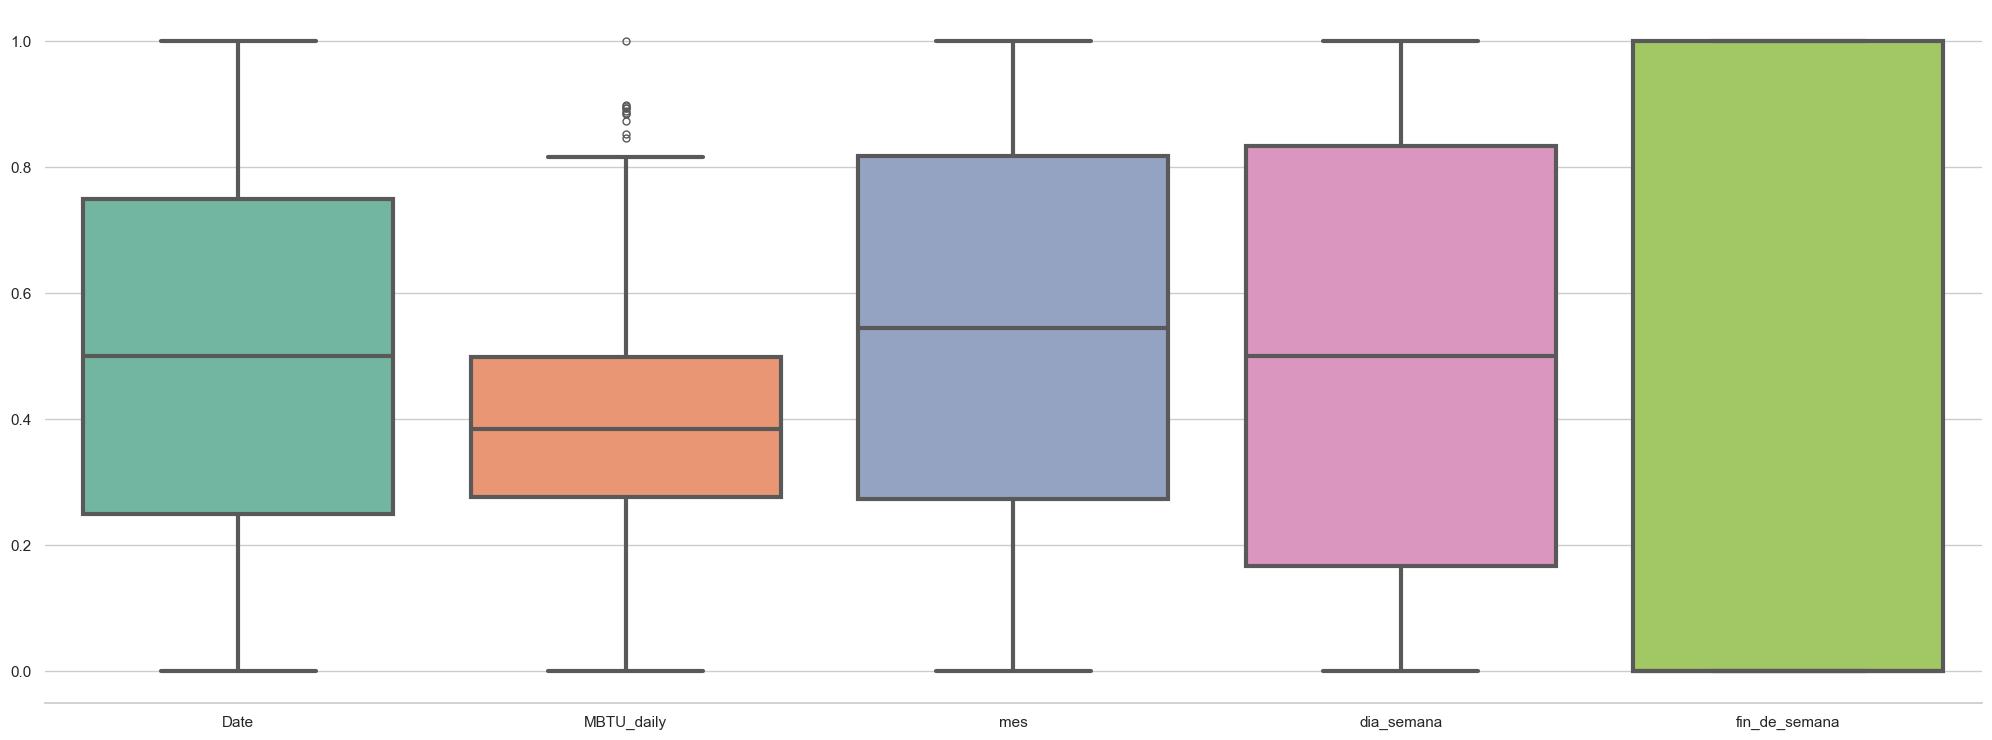

In [35]:
# Revisión de datos atipicos

df_consumo_normalizada = (df_agrupado - df_agrupado.min())/(df_agrupado.max() - df_agrupado.min())

sns.set(rc={'figure.figsize':(25,9)})
sns.set(style="whitegrid")
sns.boxplot(data = df_consumo_normalizada, linewidth = 3,
            palette="Set2", fliersize = 5)
sns.despine(left=True)

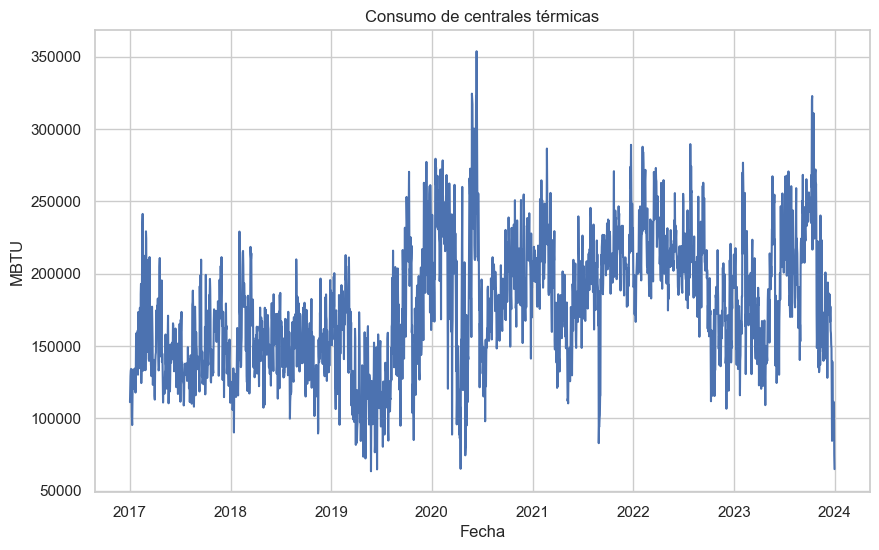

In [36]:
# Grafica exploratoria de datos apartir de una fecha inicio y fin que se encuentren en el rango inicial de descarga.
df_agrupado['Date'] = pd.to_datetime(df_agrupado['Date'])
fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango = df_agrupado[(df_agrupado['Date'] >= fecha_inicio) & (df_agrupado['Date'] <= fecha_fin)]

plt.figure(figsize=(10, 6))
plt.plot(df_rango['Date'], df_rango['MBTU_daily'])
plt.title('Consumo de centrales térmicas')
plt.xlabel('Fecha')
plt.ylabel('MBTU')
plt.grid(True)
plt.show()

#### **Lectura de los datos de aportes hidricos al sistema de generación hidroeléctrico.**

In [37]:
# Lectura de datos crudos de Valores de la hidrologia de los caudales de los rios del SIN, en metros cubicos por segundo durante el periodo 2017-2023.
# Valores de Caudal en m3/segundo.
fecha_inicio = dt.date(2017, 1, 1)
fecha_fin = dt.date(2023, 12, 31)
df_AportesH2O = objetoAPI.request_data("AporCaudal",
                                    "Rio",
                                    fecha_inicio,
                                    fecha_fin)
# tabla de datos inicial con la que se va a trabajar.
df_AportesH2O

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col],errors='ignore')
c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data['Date'] = pd.to_datetime(data['Date'],errors='ignore', format= '%Y-%m-%d')


,Id,Name,Value,Date
0,Rio,A. SAN LORENZO,22.080,2023-12-26
1,Rio,ALTOANCHICAYA,76.090,2023-12-26
2,Rio,AMOYA,12.820,2023-12-26
3,Rio,BATA,22.910,2023-12-26
4,Rio,BETANIA CP,158.939,2023-12-26
...,...,...,...,...
895,Rio,PRADO,117.520,2017-01-30
896,Rio,SAN CARLOS,74.133,2017-01-30
897,Rio,SINU URRA,130.620,2017-01-30
898,Rio,SOGAMOSO,178.131,2017-01-30


In [38]:
# Se agrupan los datos por fecha y se suman los valores de MBTU
df_AportesH2O = df_AportesH2O.groupby('Date')['Value'].sum().reset_index()
df_AportesH2O['Date'] = pd.to_datetime(df_AportesH2O['Date'])
df_AportesH2O

,Date,Value
0,2017-01-01,2072.490
1,2017-01-02,1872.113
2,2017-01-03,1531.154
3,2017-01-04,1468.189
4,2017-01-05,1655.904
...,...,...
2544,2023-12-27,2372.738
2545,2023-12-28,2327.821
2546,2023-12-29,2560.345
2547,2023-12-30,2452.609


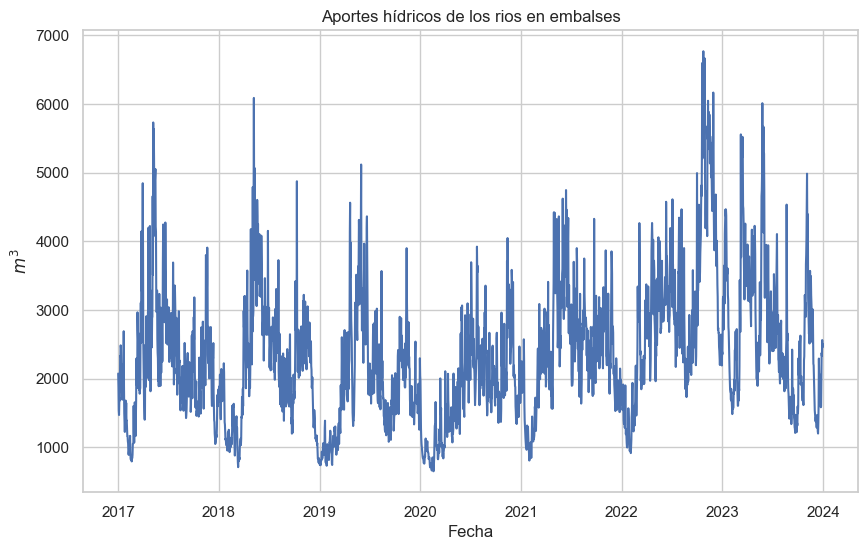

In [39]:
# Filtrado de datos en inicio y fin
fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")
df_rango = df_AportesH2O[(df_AportesH2O['Date'] >= fecha_inicio) & (df_AportesH2O['Date'] <= fecha_fin)]

plt.figure(figsize=(10, 6))
plt.plot(df_rango['Date'], df_rango['Value'])
plt.title('Aportes hídricos de los rios en embalses')
plt.xlabel('Fecha')
plt.ylabel('$m^3$')
plt.grid(True)
plt.show()

In [40]:
df_consumos = df_agrupado.merge(df_AportesH2O[['Date', 'Value']], how='left', on='Date').reset_index(drop=True)

df_consumos

,Date,MBTU_daily,mes,dia_semana,fin_de_semana,Value
0,2017-01-01,111125.1939,1,7,1,2072.490
1,2017-01-02,121709.4724,1,1,0,1872.113
2,2017-01-03,129139.7813,1,2,0,1531.154
3,2017-01-04,132915.7968,1,3,0,1468.189
4,2017-01-05,134121.5011,1,4,0,1655.904
...,...,...,...,...,...,...
2551,2023-12-27,110657.3533,12,3,0,2372.738
2552,2023-12-28,111378.0145,12,4,0,2327.821
2553,2023-12-29,109553.5381,12,5,0,2560.345
2554,2023-12-30,74725.1900,12,6,1,2452.609


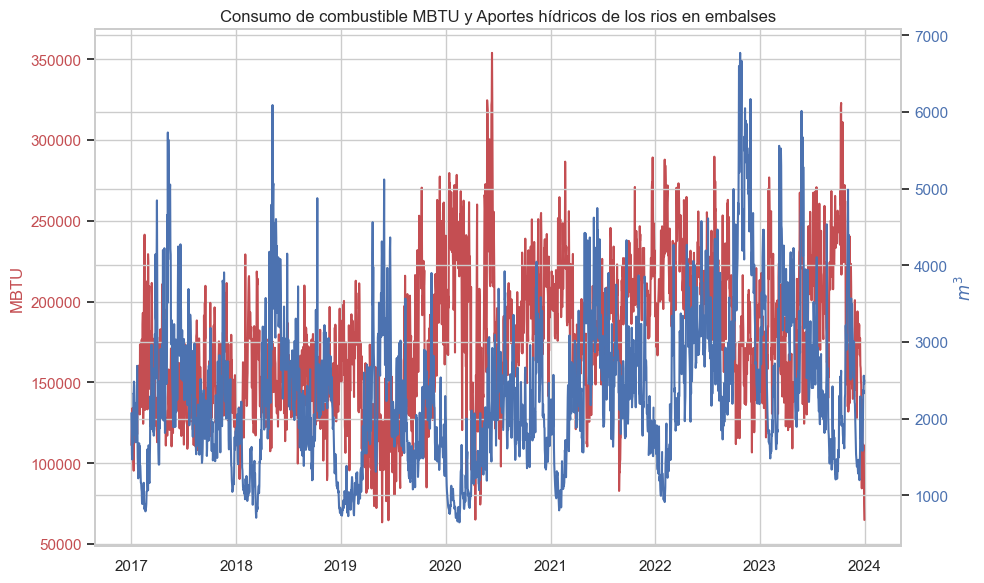

In [41]:
fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango = df_consumos[(df_consumos['Date'] >= fecha_inicio) & (df_consumos['Date'] <= fecha_fin)]

# Crear la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la primera serie en el primer eje
ax1.plot(df_rango['Date'], df_rango['MBTU_daily'], color='r', label='Consumo de combustible MBTU')
ax1.set_ylabel('MBTU', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Crear un segundo eje que comparte el mismo eje x
ax2 = ax1.twinx()

# Graficar la segunda serie en el segundo eje (por ejemplo, 'OtherValue')
ax2.plot(df_rango['Date'], df_rango['Value'], color='b', label='Aportes hídricos')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('$m^3$', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Título de la gráfica
plt.title('Consumo de combustible MBTU y Aportes hídricos de los rios en embalses')

# Mostrar la gráfica
fig.tight_layout()
plt.show()

#### **Correlación entre el comsumo de combustible y los aportes hídricos del sistema**

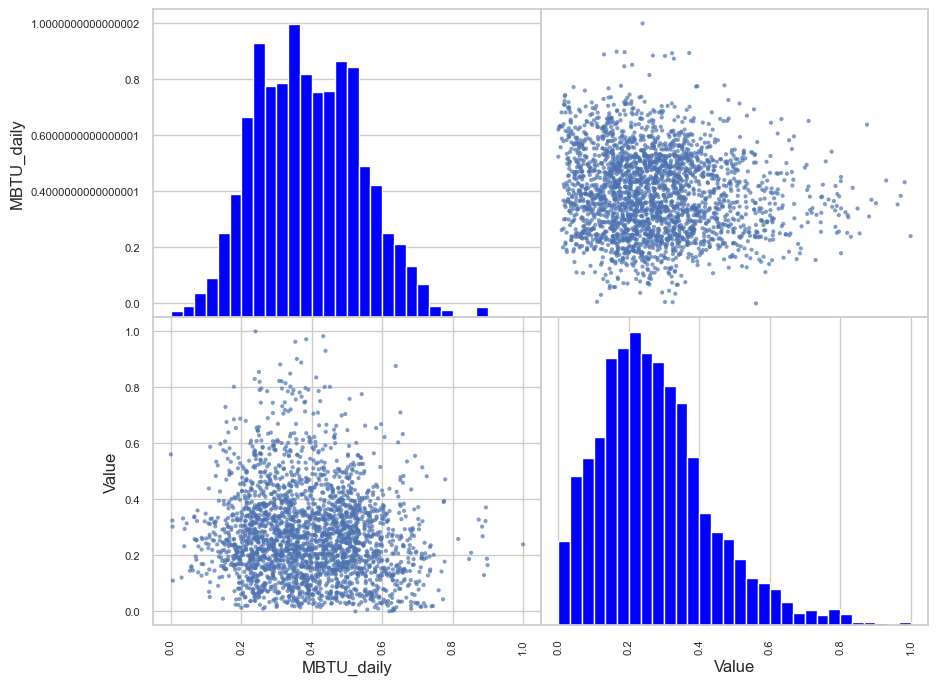

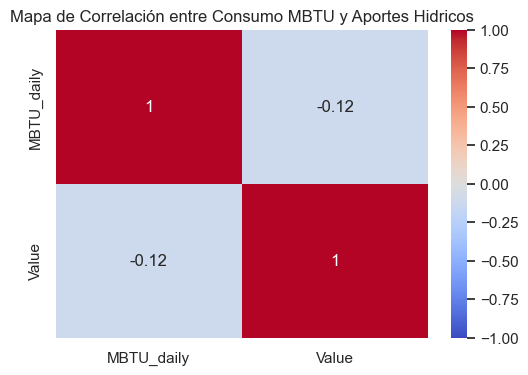

In [42]:
data_consumo_normalizada = df_consumos[['MBTU_daily', 'Value']]
data_consumo_normalizada = (data_consumo_normalizada - data_consumo_normalizada.min())/(data_consumo_normalizada.max() - data_consumo_normalizada.min())

pd.plotting.scatter_matrix(data_consumo_normalizada, alpha=0.7, figsize=(10, 8), range_padding = 0.1, diagonal='hist',
                            hist_kwds = {'bins':30, 'color':'blue'})
plt.show()

# Calcular la matriz de correlación
correlacion = data_consumo_normalizada.corr()

# Crear un mapa de calor para visualizar la correlación
plt.figure(figsize=(6, 4))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Correlación entre Consumo MBTU y Aportes Hidricos')
plt.show()

### **Análisis de correlación con el precio en bolsa Nacional**

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col],errors='ignore')
c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data['Date'] = pd.to_datetime(data['Date'],errors='ignore', format= '%Y-%m-%d')


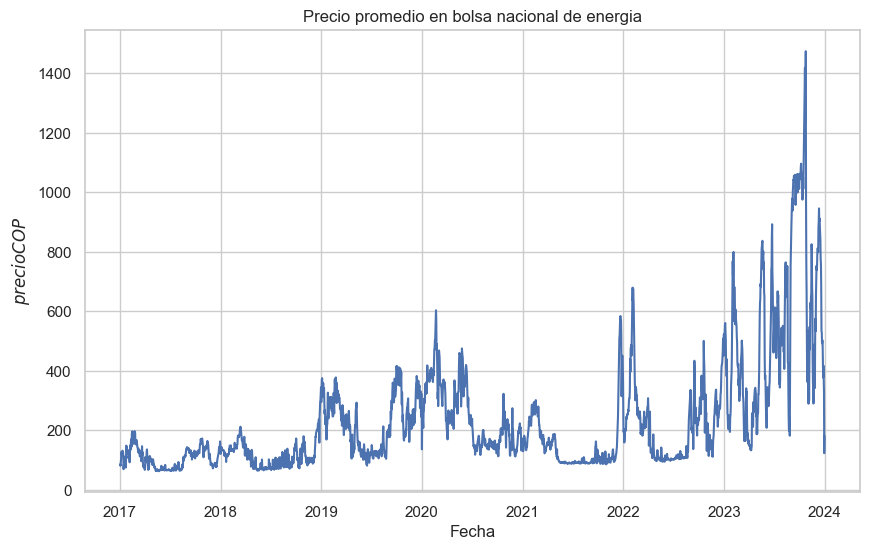

In [43]:
# Lectura de datos crudos de Valores de la hidrologia de los caudales de los rios del SIN, en metros cubicos por segundo durante el periodo 2017-2023.
# Valores de Caudal en m3/segundo.
fecha_inicio = dt.date(2017, 1, 1)
fecha_fin = dt.date(2023, 12, 31)

df_precios = objetoAPI.request_data("PrecBolsNaci",
                                    "Sistema",
                                    fecha_inicio,
                                    fecha_fin)
# tabla de datos inicial con la que se va a trabajar.
df_precios

# Los valores nulos se inicializan con cero, esto se realiza, ya que en los datos los momentos en que una central térmica no esta generando energía se muestran como Nan.
df_precios = df_precios.fillna(0)
# Se suman los valores horarios correspondientes a las 24 horas de un día para tener una variable de consumo diario.
df_precios['Precios_diarios'] = df_precios.mean(axis=1, numeric_only=True)

# Se agrupan los datos por fecha y se promedia el valor de precio en bolsa por día
df_precios = df_precios.groupby('Date')['Precios_diarios'].sum().reset_index()
df_precios['Date'] = pd.to_datetime(df_precios['Date'])

# Filtrado de datos en inicio y fin
fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")
df_rango = df_precios[(df_precios['Date'] >= fecha_inicio) & (df_precios['Date'] <= fecha_fin)]

plt.figure(figsize=(10, 6))
plt.plot(df_rango['Date'], df_rango['Precios_diarios'])
plt.title('Precio promedio en bolsa nacional de energia')
plt.xlabel('Fecha')
plt.ylabel('$precio COP$')
plt.grid(True)
plt.show()

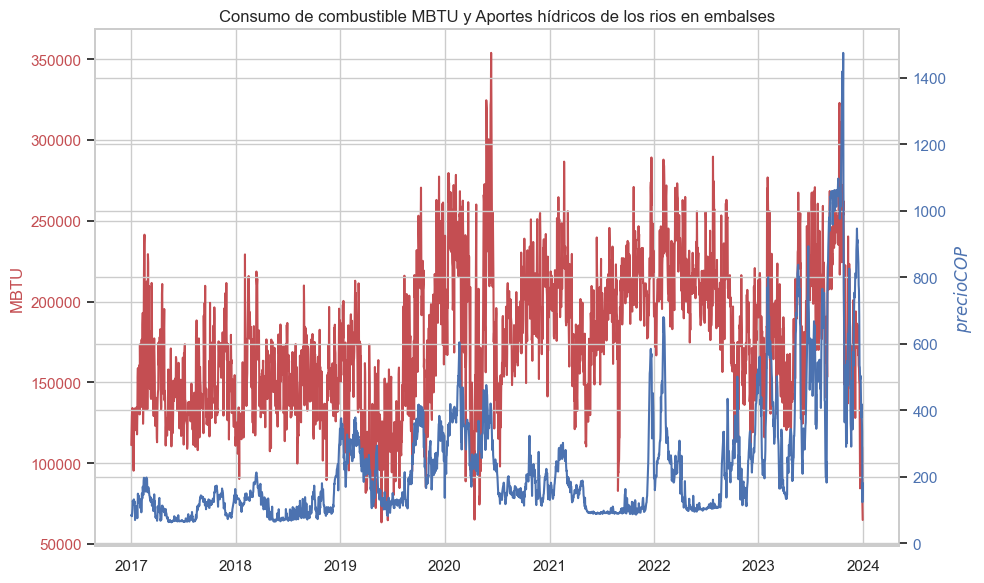

In [44]:
df_consumos_precios = df_agrupado.merge(df_precios[['Date', 'Precios_diarios']], how='left', on='Date').reset_index(drop=True)

fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango = df_consumos_precios[(df_consumos_precios['Date'] >= fecha_inicio) & (df_consumos_precios['Date'] <= fecha_fin)]

# Crear la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la primera serie en el primer eje
ax1.plot(df_rango['Date'], df_rango['MBTU_daily'], color='r', label='Consumo de combustible MBTU')
ax1.set_ylabel('MBTU', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Crear un segundo eje que comparte el mismo eje x
ax2 = ax1.twinx()

# Graficar la segunda serie en el segundo eje (por ejemplo, 'OtherValue')
ax2.plot(df_rango['Date'], df_rango['Precios_diarios'], color='b', label='Precio en bolsa')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('$precio COP$', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Título de la gráfica
plt.title('Consumo de combustible MBTU y Aportes hídricos de los rios en embalses')

# Mostrar la gráfica
fig.tight_layout()
plt.show()

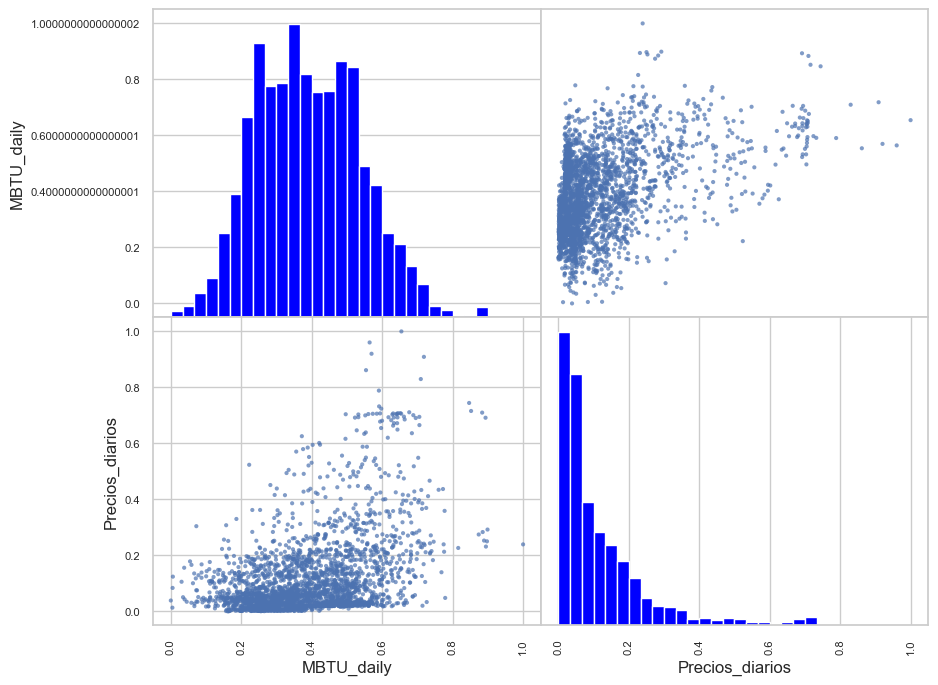

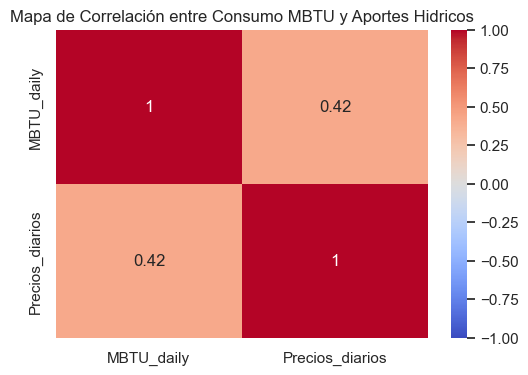

In [45]:
data_consumo_normalizada = df_consumos_precios[['MBTU_daily', 'Precios_diarios']]
data_consumo_normalizada = (data_consumo_normalizada - data_consumo_normalizada.min())/(data_consumo_normalizada.max() - data_consumo_normalizada.min())

pd.plotting.scatter_matrix(data_consumo_normalizada, alpha=0.7, figsize=(10, 8), range_padding = 0.1, diagonal='hist',
                            hist_kwds = {'bins':30, 'color':'blue'})
plt.show()

# Calcular la matriz de correlación
correlacion = data_consumo_normalizada.corr()

# Crear un mapa de calor para visualizar la correlación
plt.figure(figsize=(6, 4))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Correlación entre Consumo MBTU y Aportes Hidricos')
plt.show()

### Parte 3. Creación de datasets para entrenamiento y prueba de los modelos predictivos.
- Se debe considerar si es necesario excluir del estudio una epoca

In [46]:
# Conjunto de datos de entrenamiento y prueba para el modelo Sarimax y otros

# Separar las características (X) y la variable objetivo (y)
X = df_agrupado.drop(columns=['MBTU_daily'])  # Características
y = df_agrupado['MBTU_daily']  # Variable objetivo

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 'test_size' especifica la proporción de datos que se utilizarán para el conjunto de prueba (en este caso, 20%)
# 'random_state' asegura que la división sea reproducible

# Ahora tienes tus datos divididos en X_train, X_test (características) y y_train, y_test (variable objetivo)
# Puedes utilizar X_train y y_train para entrenar tu modelo y X_test para evaluar su rendimiento


In [47]:
# Paso 2: Normalización de datos
scaler = MinMaxScaler()
df_agrupado['MBTU_daily'] = scaler.fit_transform(df_agrupado['MBTU_daily'].values.reshape(-1, 1))

# Paso 3: Creación de secuencias
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

sequence_length = 2  # Longitud de la secuencia
X = create_sequences(df_agrupado['MBTU_daily'].values, sequence_length)
y = df_agrupado['MBTU_daily'].values[sequence_length:]

# Paso 4: División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# X_train y y_train serán utilizados para entrenar el modelo de RNN
# X_test y y_test serán utilizados para evaluar el rendimiento del modelo
X_train

array([[0.16449366, 0.20092571],
       [0.20092571, 0.22650151],
       [0.22650151, 0.23949889],
       ...,
       [0.49681368, 0.53595452],
       [0.53595452, 0.4682145 ],
       [0.4682145 , 0.46303876]])

**Parte 4.** Análisis exploratorio de verificaciones en serie de tiempo.

- Se realiza análisis de estacionalidad, tendencia y error de los datos.
- Se reliza test de dicked fuller.
- El análisis y pruebas se realizan en base al dataframe "df_rango" en un rango particular de datos.

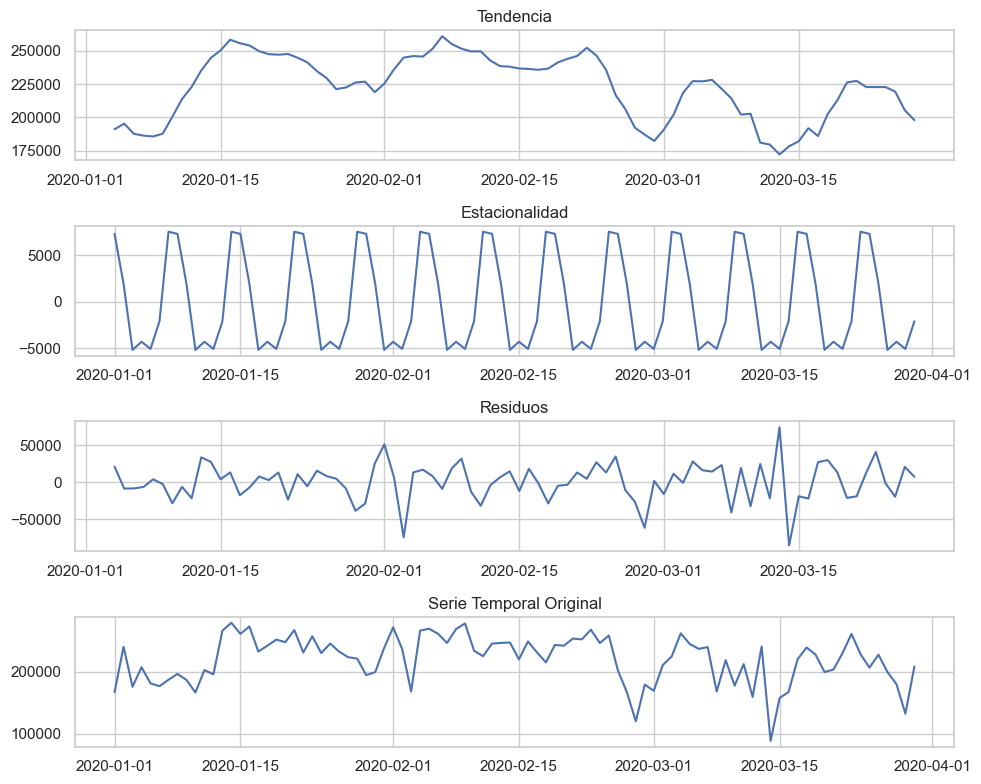

In [68]:
fecha_inicio_descom = dt.datetime.strptime("2020-1-1", "%Y-%m-%d")
fecha_fin_descom = dt.datetime.strptime("2020-3-30", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango_descom = df_consumos_precios[(df_consumos_precios['Date'] >= fecha_inicio_descom) & (df_consumos_precios['Date'] <= fecha_fin_descom)]

# Descomposición de series temporales
df_rango_descom.set_index('Date', inplace=True)
decomposition = seasonal_decompose(df_rango_descom['MBTU_daily'], model='additive')
# Visualización de la descomposición
plt.figure(figsize=(10, 8))

# Tendencia
plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Tendencia')

# Estacionalidad
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Estacionalidad')

# Residuos
plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residuos')

# Serie Temporal Original
plt.subplot(414)
plt.plot(df_rango_descom['MBTU_daily'])
plt.title('Serie Temporal Original')

plt.tight_layout()
plt.show()

**Análisis resultados**
Se puede notar en la descomposición de la serie temporal se tiene una tendencia variante en el tiempo sin un patro muy claro. Una parte estacional que tiene concordancia con los datos pero de la mano con residuos de esta descomposición que tienen un comportamiento variable en los diferentes años.

In [50]:
# Test de Dicked Fuller
# Aplicar el test de Dickey-Fuller
result = sm.tsa.adfuller(df_rango['MBTU_daily'])

# Mostrar los resultados del test
print('Estadística ADF:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])

# Interpretación de los resultados
if result[1] <= 0.05:
    print("La serie temporal es estacionaria (rechazamos la hipótesis nula de la presencia de una raíz unitaria).")
else:
    print("La serie temporal no es estacionaria (no podemos rechazar la hipótesis nula de la presencia de una raíz unitaria).")

Estadística ADF: -4.210002537144271
Valor p: 0.000633677379122661
Valores críticos: {'1%': -3.432939379929173, '5%': -2.862683979868293, '10%': -2.5673789838429837}
La serie temporal es estacionaria (rechazamos la hipótesis nula de la presencia de una raíz unitaria).


## **Parte 4.** Modelación inicial con ARIMA

## **Parte 4.** Modelación con SARIMAX

In [51]:
!pip install pmdarima

You should consider upgrading via the 'C:\Users\itco10302\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [52]:
!pip install numpy==1.26.4

You should consider upgrading via the 'C:\Users\itco10302\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [77]:
scaler = MinMaxScaler()
df_consumos_scaler = scaler.fit_transform(df_consumos[['MBTU_daily', 'Value']])
df_consumos_scaler = pd.DataFrame(df_consumos_scaler, columns = ['MBTU_daily', 'Value'])
print(df_consumos_scaler.head(8))

# Dividir los datos en entrenamiento y prueba
train_size = int(len(df_consumos['MBTU_daily']) * 0.8)
test_size = int(len(df_consumos['MBTU_daily']) * 0.2)

train, test = df_consumos_scaler['MBTU_daily'][:train_size], df_consumos_scaler['MBTU_daily'][train_size:]
# Datos de series temporales (reemplaza esto con tus propios datos)
# series = ...


   MBTU_daily     Value
0    0.164494  0.232635
1    0.200926  0.199898
2    0.226502  0.144193
3    0.239499  0.133906
4    0.243649  0.164574
5    0.225055  0.173321
6    0.190477  0.168611
7    0.126809  0.274162


In [73]:
import pmdarima as pm

# Búsqueda de hiperparámetros usando AIC para seleccionar el mejor modelo
model_auto = pm.auto_arima(train, 
                           seasonal=True, 
                           m=7,  # Ajusta m según el período de estacionalidad
                           stepwise=True, 
                           trace=True)

# Parámetros óptimos
optimal_order = model_auto.order
optimal_seasonal_order = model_auto.seasonal_order

print(f'Optimal order: {optimal_order}')
print(f'Optimal seasonal order: {optimal_seasonal_order}')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-3948.627, Time=5.35 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-3631.710, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-3769.304, Time=0.86 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-3824.762, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-3633.701, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=-3948.471, Time=4.41 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=-3950.066, Time=4.02 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=-3942.231, Time=4.35 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=-3957.571, Time=9.05 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=-3955.755, Time=8.27 sec
 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=-3950.548, Time=6.13 sec
 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=-3946.122, Time=5.60 sec
 ARIMA(3,1,2)(2,0,0)[7] intercept   : AIC=-3953.259, Time=9.30 sec
 ARIMA(2,1,3)(2,0,0)[7] intercept   : AIC=-3956.539, Time=9.26 sec
 ARIMA(1,1,1)(2,0,0

In [76]:
!pip install skforecast

You should consider upgrading via the 'C:\Users\itco10302\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [78]:
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from pmdarima import ARIMA
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Create and fit ForecasterSarimax
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=ARIMA(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(y=train)
forecaster

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ForecasterSarimax 
Regressor:  ARIMA(12,1,1)(0,0,0)[0] intercept 
Regressor parameters: {'maxiter': 200, 'method': 'lbfgs', 'order': (12, 1, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': False, 'trend': None, 'with_intercept': True} 
fit_kwargs: {} 
Window size: 1 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 2043] 
Training index type: RangeIndex 
Training index frequency: 1 
Creation date: 2024-10-04 11:06:54 
Last fit date: 2024-10-04 11:07:00 
Index seen by the forecaster: RangeIndex(start=0, stop=2044, step=1) 
Skforecast version: 0.13.0 
Python version: 3.10.0 
Forecaster id: None 

In [79]:

# Predict
# ======================================================================================
predictions = forecaster.predict(steps=test_size)
predictions.head(3)

2044    0.485668
2045    0.513271
2046    0.515917
Name: pred, dtype: float64

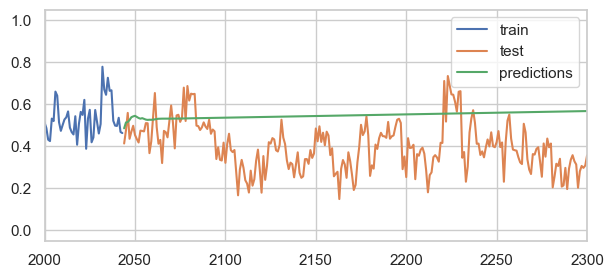

In [85]:

# Plot predictions
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')

# Limitar el rango del eje x (especificar fechas)
ax.set_xlim(2000,2300)  # Ajusta las fechas según tu dataset

ax.legend()
plt.show()

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error (MSE) en conjunto de validación: 0.02092008760350828
Mean Squared Error (MSE) en conjunto de prueba: 0.05781706566762943


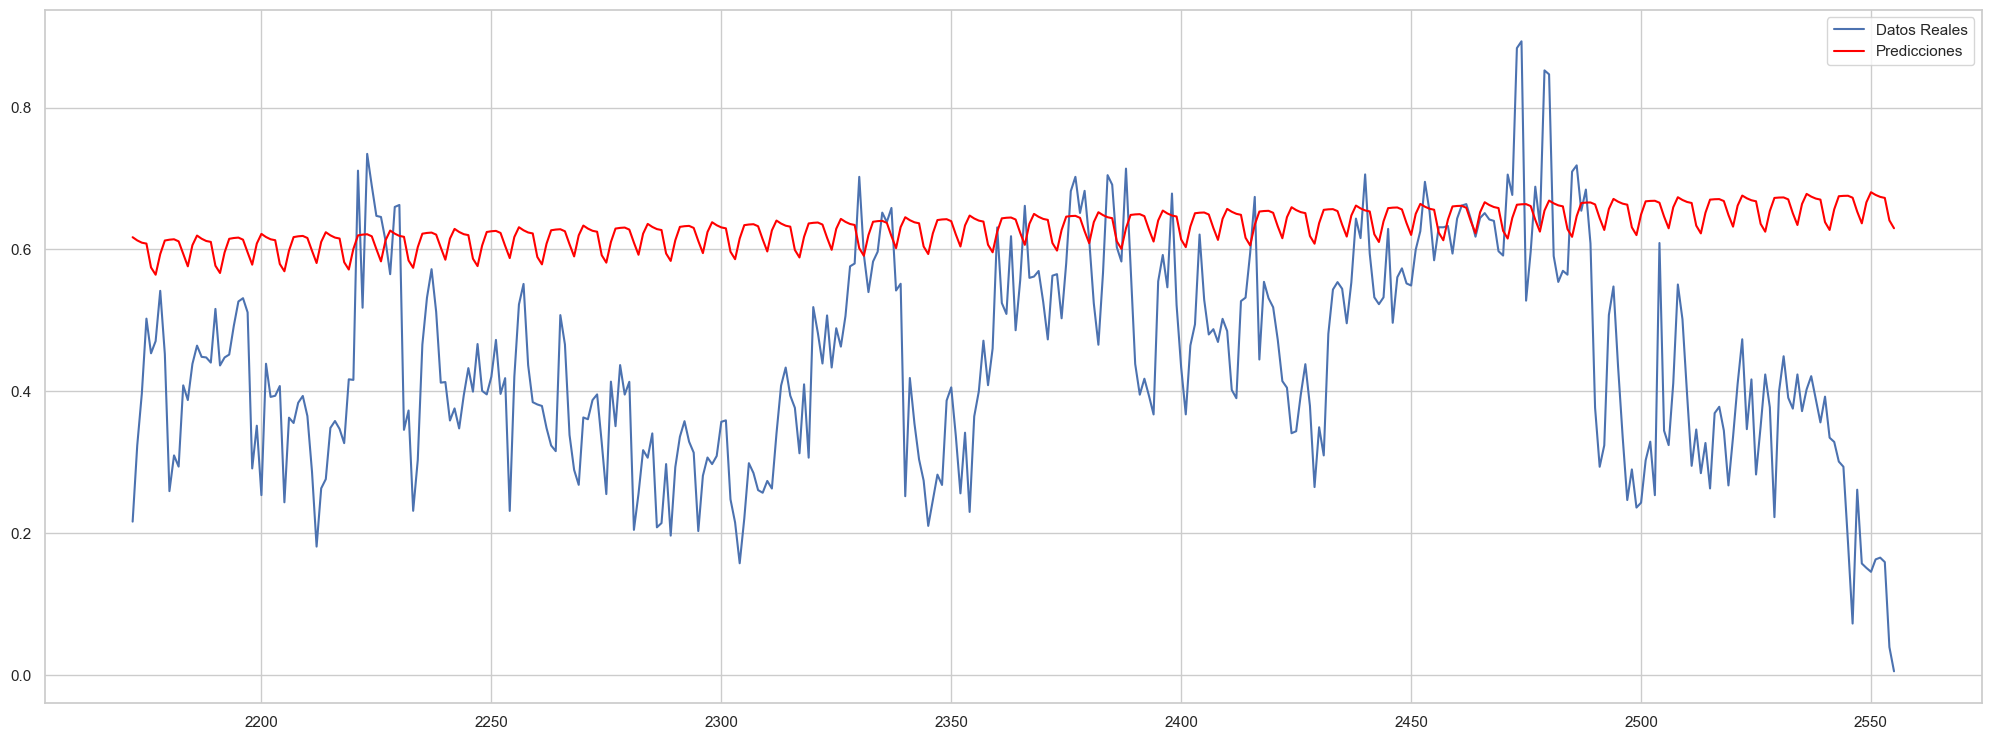

In [75]:
from scipy.integrate import tplquad
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error



# Definir y ajustar el modelo SARIMA utilizando los datos de entrenamiento

model = SARIMAX(train, order=optimal_order, seasonal_order=optimal_seasonal_order)
model_fit = model.fit(maxiter=1000, disp=False)

# Realizar predicciones en el conjunto de validación
predictions = model_fit.predict(start=valid.index[0], end=valid.index[-1])

mse = mean_squared_error(valid, predictions)
print(f'Mean Squared Error (MSE) en conjunto de validación: {mse}')

# Realizar predicciones en el conjunto de prueba
test_predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

test_mse = mean_squared_error(test, test_predictions)
print(f'Mean Squared Error (MSE) en conjunto de prueba: {test_mse}')

# Visualizar las predicciones y los datos reales en el conjunto de prueba
plt.plot(test, label='Datos Reales')
plt.plot(test_predictions, color='red', label='Predicciones')
plt.legend()
#plt.savefig('SARIMA_1')
plt.show()
